Change Log:
- v23 - build two model for each price group, limit the training set to each target price group
- v20 - lower learning rate = 0.0008, add height_r and top_floor index
- v16 - change parameters (some from model 05), rm reduce to 68
- v14 - change random seed
- v10 - remove features based on feature importance results (exp-l04-per-area)

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

In [2]:
model_name = 'model-23-lgb-binary'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_duplicated_train = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'height_r', 'dt_diff_building_complete_dt_txn_dt']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)

In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

# Add price group predictions
train_group = pd.read_csv('output/metamodel-03-lgb-binary-cv.csv')  # add price group
train = train.merge(train_group, how='left', on='building_id')
assert not train['price_group_pred'].isnull().any()
train.check()

test_group = pd.read_csv('output/metamodel-03-lgb-binary-test-one.csv')  # add price group using one
test = test.merge(test_group, how='left', on='building_id')
assert not test['price_group_pred'].isnull().any()
test.check()

price_groups = sorted(train['price_group_pred'].unique())
print('Price groups:', 'N =', len(price_groups), price_groups)
print('Binary classification accuracy (train):', 
      '%.5f'%(train['price_group'] == train['price_group_pred']).mean())

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,price_group,price_group_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775,0,0
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,115,1,15872,1,32221,1,40.07357348973039,3321452.0,1,1
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373,1,1
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045,1,1
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696,0,0
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949,0,0
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478,1,1
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225,1,1
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832,1,1
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061,1,1


shape = (60000, 237)


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,price_group_pred
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,21,1,129,1,3991,1,8409,1,105.4622312795739,1
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,44,1,67,1,1950,1,10725,1,100.81980868401074,0
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,3,1,35,1,3707,1,19459,1,259.8005430183116,1
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,60,1,144,1,6487,1,29400,1,22.941906168328487,1
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,18,1,76,1,1346,1,3280,1,181.21309507601745,0
9995,UEeCDaAJzPwdKKKA,8,3,19494,6,3,2,12115,2,NaN,...,5,1,35,1,1118,1,3408,1,276.63801953982124,0
9996,i0fgbPaQsDWs7Q87,8,13,19166,13,0,2,17502,0,8.654350043224781,...,23,1,66,1,3773,1,16164,1,46.55561753672866,1
9997,YunNwAhcqkf6YclI,8,5,19340,3,4,2,11324,2,NaN,...,7,1,42,1,1354,1,5693,1,13.622703036125506,0
9998,A2NotxtRY9MYoWMl,8,7,18184,5,1,2,7885,2,NaN,...,182,1,840,1,6469,1,31383,1,91.48925980597359,1
9999,kKvgBXiA50gRmQhP,8,21,20370,6,3,2,11142,2,NaN,...,26,1,119,1,3769,1,9529,1,124.55299965753014,0


shape = (10000, 235)
Price groups: N = 2 [0, 1]
Binary classification accuracy (train): 0.95893


### Preprocessing

In [9]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [11]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
#feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Params

In [12]:
# params
# parameters from model 10: 24, 300, 0.5, 10, 0.1, 0.0
# parameters from model 5: 24, 258, 0.4, 6, 0.04, 0.02
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.0005, # 0.001
          'max_depth': 32,
          'num_leaves': 127,           # may reduce in dim-reduction exp
          'feature_fraction': 0.4,
          'min_data_in_leaf': 18,
          'lambda_l1': 0.0,
          'lambda_l2': 0.05,
          'max_bin': 511,
          'min_sum_hessian_in_leaf': 0.1,
          'min_data_per_group': 50,
          'seed': 2323,
         }

lgb_other_params = {'num_boost_round': 1000000,  # expected to stop 250000
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                    'keep_training_booster': True,
                   }


### kfold cross-predict

In [13]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []; mapes = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)
    
    # split price group
    best_iters = []
    for pg in price_groups:
        df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
        df_val_g = df_val.loc[df_val['price_group_pred'] == pg]

        if is_duplicated_train:
            df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)
        
        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()
        lgb_val = lgb.Dataset(df_val_g[cols_feats], df_val_g[col_target], reference=lgb_train).construct()
        
        # train model    
        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
        best_iters.append(model.best_iteration)

        # Predict on val set
        val_pg_mask = df_val['price_group_pred'] == pg
        df_val.loc[val_pg_mask, col_target+'_pred'] = (
            model.predict(df_val.loc[val_pg_mask, cols_feats])
        )
        
        # Predict on test set
        test_pg_mask = df_test['price_group_pred'] == pg
        predicts_test.loc[test_pg_mask, 'target_{}'.format(i)] = (
            model.predict(df_test.loc[test_pg_mask, cols_feats])
        )
    
    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    mapes.append(mape)
    
    y_pred_final = post_processing(df_val[col_target+'_pred'], df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)
    best_iterations.append(best_iters)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0211741
[4000]	valid_0's mape: 0.0165378
[6000]	valid_0's mape: 0.0146812
[8000]	valid_0's mape: 0.0137759
[10000]	valid_0's mape: 0.0132464
[12000]	valid_0's mape: 0.0128943
[14000]	valid_0's mape: 0.0126475
[16000]	valid_0's mape: 0.0124613
[18000]	valid_0's mape: 0.0123093
[20000]	valid_0's mape: 0.0121863
[22000]	valid_0's mape: 0.0120872
[24000]	valid_0's mape: 0.0120016
[26000]	valid_0's mape: 0.0119273
[28000]	valid_0's mape: 0.0118641
[30000]	valid_0's mape: 0.0118065
[32000]	valid_0's mape: 0.0117564
[34000]	valid_0's mape: 0.0117115
[36000]	valid_0's mape: 0.0116726
[38000]	valid_0's mape: 0.011638
[40000]	valid_0's mape: 0.0116067
[42000]	valid_0's mape: 0.0115785
[44000]	valid_0's mape: 0.0115518
[46000]	valid_0's mape: 0.0115264
[48000]	valid_0's mape: 0.0115036
[50000]	valid_0's mape: 0.0114825
[52000]	valid_0's mape: 0.0114625
[54000]	valid_0's mape: 0.0114445
[56000]	valid_0's mape:

[472000]	valid_0's mape: 0.0111029
[474000]	valid_0's mape: 0.0111029
[476000]	valid_0's mape: 0.0111028
[478000]	valid_0's mape: 0.0111028
[480000]	valid_0's mape: 0.0111028
[482000]	valid_0's mape: 0.0111027
[484000]	valid_0's mape: 0.0111027
[486000]	valid_0's mape: 0.0111026
[488000]	valid_0's mape: 0.0111026
[490000]	valid_0's mape: 0.0111025
[492000]	valid_0's mape: 0.0111025
[494000]	valid_0's mape: 0.0111024
[496000]	valid_0's mape: 0.0111024
[498000]	valid_0's mape: 0.0111024
[500000]	valid_0's mape: 0.0111023
[502000]	valid_0's mape: 0.0111023
[504000]	valid_0's mape: 0.0111023
[506000]	valid_0's mape: 0.0111023
[508000]	valid_0's mape: 0.0111022
[510000]	valid_0's mape: 0.0111022
[512000]	valid_0's mape: 0.0111021
[514000]	valid_0's mape: 0.0111021
[516000]	valid_0's mape: 0.0111021
[518000]	valid_0's mape: 0.011102
[520000]	valid_0's mape: 0.011102
[522000]	valid_0's mape: 0.0111019
[524000]	valid_0's mape: 0.0111019
[526000]	valid_0's mape: 0.0111019
[528000]	valid_0's map

[250000]	valid_0's mape: 0.00732339
[252000]	valid_0's mape: 0.00732307
[254000]	valid_0's mape: 0.00732282
[256000]	valid_0's mape: 0.00732254
[258000]	valid_0's mape: 0.00732241
[260000]	valid_0's mape: 0.0073222
[262000]	valid_0's mape: 0.00732201
[264000]	valid_0's mape: 0.00732175
[266000]	valid_0's mape: 0.00732158
[268000]	valid_0's mape: 0.00732133
[270000]	valid_0's mape: 0.00732115
[272000]	valid_0's mape: 0.00732098
[274000]	valid_0's mape: 0.00732081
[276000]	valid_0's mape: 0.00732062
[278000]	valid_0's mape: 0.0073204
[280000]	valid_0's mape: 0.00732025
[282000]	valid_0's mape: 0.00732013
[284000]	valid_0's mape: 0.00732001
[286000]	valid_0's mape: 0.00731983
[288000]	valid_0's mape: 0.00731964
[290000]	valid_0's mape: 0.00731949
[292000]	valid_0's mape: 0.00731931
[294000]	valid_0's mape: 0.00731919
Early stopping, best iteration is:
[294259]	valid_0's mape: 0.00731918
(Fold 0) score, mse, mae, mape: 5802.87463, 0.03634, 0.12196, 0.00916.
Training until validation scores

[416000]	valid_0's mape: 0.0114031
[418000]	valid_0's mape: 0.011403
[420000]	valid_0's mape: 0.0114029
[422000]	valid_0's mape: 0.0114028
[424000]	valid_0's mape: 0.0114027
[426000]	valid_0's mape: 0.0114026
[428000]	valid_0's mape: 0.0114025
[430000]	valid_0's mape: 0.0114024
[432000]	valid_0's mape: 0.0114023
[434000]	valid_0's mape: 0.0114022
[436000]	valid_0's mape: 0.0114021
[438000]	valid_0's mape: 0.011402
[440000]	valid_0's mape: 0.0114019
[442000]	valid_0's mape: 0.0114018
[444000]	valid_0's mape: 0.0114017
[446000]	valid_0's mape: 0.0114016
[448000]	valid_0's mape: 0.0114015
[450000]	valid_0's mape: 0.0114015
[452000]	valid_0's mape: 0.0114014
[454000]	valid_0's mape: 0.0114013
[456000]	valid_0's mape: 0.0114013
[458000]	valid_0's mape: 0.0114012
[460000]	valid_0's mape: 0.0114011
[462000]	valid_0's mape: 0.011401
[464000]	valid_0's mape: 0.0114009
[466000]	valid_0's mape: 0.0114009
[468000]	valid_0's mape: 0.0114008
[470000]	valid_0's mape: 0.0114007
[472000]	valid_0's mape

[188000]	valid_0's mape: 0.00739972
[190000]	valid_0's mape: 0.00739895
[192000]	valid_0's mape: 0.00739811
[194000]	valid_0's mape: 0.00739735
[196000]	valid_0's mape: 0.00739658
[198000]	valid_0's mape: 0.00739599
[200000]	valid_0's mape: 0.00739535
[202000]	valid_0's mape: 0.00739482
[204000]	valid_0's mape: 0.00739427
[206000]	valid_0's mape: 0.00739371
[208000]	valid_0's mape: 0.00739321
[210000]	valid_0's mape: 0.00739272
[212000]	valid_0's mape: 0.00739213
[214000]	valid_0's mape: 0.0073917
[216000]	valid_0's mape: 0.00739117
[218000]	valid_0's mape: 0.00739071
[220000]	valid_0's mape: 0.00739019
[222000]	valid_0's mape: 0.00738963
[224000]	valid_0's mape: 0.00738918
[226000]	valid_0's mape: 0.00738866
[228000]	valid_0's mape: 0.00738822
[230000]	valid_0's mape: 0.00738784
[232000]	valid_0's mape: 0.00738755
[234000]	valid_0's mape: 0.00738721
[236000]	valid_0's mape: 0.00738692
[238000]	valid_0's mape: 0.00738655
[240000]	valid_0's mape: 0.00738626
[242000]	valid_0's mape: 0.00

[126000]	valid_0's mape: 0.0114412
[128000]	valid_0's mape: 0.0114382
[130000]	valid_0's mape: 0.0114354
[132000]	valid_0's mape: 0.0114329
[134000]	valid_0's mape: 0.0114306
[136000]	valid_0's mape: 0.0114281
[138000]	valid_0's mape: 0.0114259
[140000]	valid_0's mape: 0.0114235
[142000]	valid_0's mape: 0.0114212
[144000]	valid_0's mape: 0.0114192
[146000]	valid_0's mape: 0.0114171
[148000]	valid_0's mape: 0.0114153
[150000]	valid_0's mape: 0.0114134
[152000]	valid_0's mape: 0.0114116
[154000]	valid_0's mape: 0.0114099
[156000]	valid_0's mape: 0.0114081
[158000]	valid_0's mape: 0.0114064
[160000]	valid_0's mape: 0.0114048
[162000]	valid_0's mape: 0.0114035
[164000]	valid_0's mape: 0.0114019
[166000]	valid_0's mape: 0.0114005
[168000]	valid_0's mape: 0.0113991
[170000]	valid_0's mape: 0.0113977
[172000]	valid_0's mape: 0.0113964
[174000]	valid_0's mape: 0.0113951
[176000]	valid_0's mape: 0.0113941
[178000]	valid_0's mape: 0.0113931
[180000]	valid_0's mape: 0.0113921
[182000]	valid_0's m

[596000]	valid_0's mape: 0.0113509
[598000]	valid_0's mape: 0.0113509
[600000]	valid_0's mape: 0.0113509
[602000]	valid_0's mape: 0.0113508
[604000]	valid_0's mape: 0.0113508
[606000]	valid_0's mape: 0.0113508
[608000]	valid_0's mape: 0.0113508
[610000]	valid_0's mape: 0.0113508
[612000]	valid_0's mape: 0.0113508
[614000]	valid_0's mape: 0.0113507
[616000]	valid_0's mape: 0.0113507
[618000]	valid_0's mape: 0.0113507
[620000]	valid_0's mape: 0.0113507
[622000]	valid_0's mape: 0.0113507
[624000]	valid_0's mape: 0.0113506
[626000]	valid_0's mape: 0.0113506
[628000]	valid_0's mape: 0.0113506
[630000]	valid_0's mape: 0.0113506
[632000]	valid_0's mape: 0.0113506
[634000]	valid_0's mape: 0.0113505
[636000]	valid_0's mape: 0.0113505
[638000]	valid_0's mape: 0.0113505
[640000]	valid_0's mape: 0.0113505
[642000]	valid_0's mape: 0.0113505
[644000]	valid_0's mape: 0.0113505
[646000]	valid_0's mape: 0.0113504
[648000]	valid_0's mape: 0.0113504
Early stopping, best iteration is:
[648654]	valid_0's m

[412000]	valid_0's mape: 0.00737618
[414000]	valid_0's mape: 0.00737614
[416000]	valid_0's mape: 0.00737611
[418000]	valid_0's mape: 0.00737607
[420000]	valid_0's mape: 0.00737605
[422000]	valid_0's mape: 0.00737601
[424000]	valid_0's mape: 0.00737594
[426000]	valid_0's mape: 0.00737591
[428000]	valid_0's mape: 0.00737589
[430000]	valid_0's mape: 0.00737586
[432000]	valid_0's mape: 0.0073758
[434000]	valid_0's mape: 0.00737574
[436000]	valid_0's mape: 0.00737572
[438000]	valid_0's mape: 0.00737569
Early stopping, best iteration is:
[438736]	valid_0's mape: 0.00737568
(Fold 2) score, mse, mae, mape: 5911.86990, 0.03962, 0.12384, 0.00931.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0208728
[4000]	valid_0's mape: 0.0165153
[6000]	valid_0's mape: 0.0147938
[8000]	valid_0's mape: 0.0139679
[10000]	valid_0's mape: 0.0134915
[12000]	valid_0's mape: 0.0131842
[14000]	valid_0's mape: 0.0129663
[16000]	valid_0's mape: 0.012799
[18000]	valid_0's mape: 

[436000]	valid_0's mape: 0.0113935
[438000]	valid_0's mape: 0.0113935
[440000]	valid_0's mape: 0.0113935
[442000]	valid_0's mape: 0.0113934
[444000]	valid_0's mape: 0.0113934
[446000]	valid_0's mape: 0.0113934
[448000]	valid_0's mape: 0.0113934
[450000]	valid_0's mape: 0.0113933
[452000]	valid_0's mape: 0.0113933
[454000]	valid_0's mape: 0.0113932
[456000]	valid_0's mape: 0.0113932
[458000]	valid_0's mape: 0.0113932
[460000]	valid_0's mape: 0.0113931
[462000]	valid_0's mape: 0.0113931
[464000]	valid_0's mape: 0.011393
[466000]	valid_0's mape: 0.011393
[468000]	valid_0's mape: 0.0113929
[470000]	valid_0's mape: 0.0113929
[472000]	valid_0's mape: 0.0113928
[474000]	valid_0's mape: 0.0113928
[476000]	valid_0's mape: 0.0113928
[478000]	valid_0's mape: 0.0113927
[480000]	valid_0's mape: 0.0113927
[482000]	valid_0's mape: 0.0113927
[484000]	valid_0's mape: 0.0113926
[486000]	valid_0's mape: 0.0113926
[488000]	valid_0's mape: 0.0113926
[490000]	valid_0's mape: 0.0113926
Early stopping, best i

[50000]	valid_0's mape: 0.0115472
[52000]	valid_0's mape: 0.0115289
[54000]	valid_0's mape: 0.0115111
[56000]	valid_0's mape: 0.0114943
[58000]	valid_0's mape: 0.0114788
[60000]	valid_0's mape: 0.011463
[62000]	valid_0's mape: 0.0114484
[64000]	valid_0's mape: 0.0114355
[66000]	valid_0's mape: 0.0114231
[68000]	valid_0's mape: 0.011411
[70000]	valid_0's mape: 0.0113999
[72000]	valid_0's mape: 0.0113887
[74000]	valid_0's mape: 0.0113785
[76000]	valid_0's mape: 0.0113686
[78000]	valid_0's mape: 0.0113591
[80000]	valid_0's mape: 0.0113501
[82000]	valid_0's mape: 0.0113419
[84000]	valid_0's mape: 0.0113343
[86000]	valid_0's mape: 0.0113269
[88000]	valid_0's mape: 0.0113196
[90000]	valid_0's mape: 0.0113128
[92000]	valid_0's mape: 0.0113067
[94000]	valid_0's mape: 0.0113007
[96000]	valid_0's mape: 0.011295
[98000]	valid_0's mape: 0.0112897
[100000]	valid_0's mape: 0.0112847
[102000]	valid_0's mape: 0.0112797
[104000]	valid_0's mape: 0.011275
[106000]	valid_0's mape: 0.0112706
[108000]	valid

[522000]	valid_0's mape: 0.0111226
[524000]	valid_0's mape: 0.0111225
[526000]	valid_0's mape: 0.0111225
[528000]	valid_0's mape: 0.0111225
[530000]	valid_0's mape: 0.0111224
[532000]	valid_0's mape: 0.0111224
[534000]	valid_0's mape: 0.0111223
[536000]	valid_0's mape: 0.0111223
[538000]	valid_0's mape: 0.0111223
[540000]	valid_0's mape: 0.0111222
[542000]	valid_0's mape: 0.0111222
[544000]	valid_0's mape: 0.0111222
[546000]	valid_0's mape: 0.0111221
[548000]	valid_0's mape: 0.0111221
[550000]	valid_0's mape: 0.011122
[552000]	valid_0's mape: 0.011122
[554000]	valid_0's mape: 0.011122
[556000]	valid_0's mape: 0.0111219
[558000]	valid_0's mape: 0.0111219
[560000]	valid_0's mape: 0.0111219
[562000]	valid_0's mape: 0.0111218
[564000]	valid_0's mape: 0.0111218
[566000]	valid_0's mape: 0.0111218
[568000]	valid_0's mape: 0.0111217
[570000]	valid_0's mape: 0.0111217
[572000]	valid_0's mape: 0.0111217
[574000]	valid_0's mape: 0.0111217
[576000]	valid_0's mape: 0.0111216
[578000]	valid_0's mape

[148000]	valid_0's mape: 0.00755739
[150000]	valid_0's mape: 0.00755613
[152000]	valid_0's mape: 0.00755495
[154000]	valid_0's mape: 0.00755383
[156000]	valid_0's mape: 0.00755279
[158000]	valid_0's mape: 0.00755194
[160000]	valid_0's mape: 0.00755096
[162000]	valid_0's mape: 0.00755026
[164000]	valid_0's mape: 0.00754946
[166000]	valid_0's mape: 0.00754871
[168000]	valid_0's mape: 0.00754779
[170000]	valid_0's mape: 0.00754691
[172000]	valid_0's mape: 0.00754588
[174000]	valid_0's mape: 0.00754506
[176000]	valid_0's mape: 0.00754431
[178000]	valid_0's mape: 0.00754344
[180000]	valid_0's mape: 0.00754287
[182000]	valid_0's mape: 0.00754219
[184000]	valid_0's mape: 0.00754138
[186000]	valid_0's mape: 0.00754079
[188000]	valid_0's mape: 0.00754031
[190000]	valid_0's mape: 0.00753972
[192000]	valid_0's mape: 0.00753912
[194000]	valid_0's mape: 0.00753865
[196000]	valid_0's mape: 0.00753802
[198000]	valid_0's mape: 0.00753746
[200000]	valid_0's mape: 0.00753696
[202000]	valid_0's mape: 0.0

In [14]:
print('Total run time:', time.time() - t0)

Total run time: 67214.68470621109


In [15]:
print('Kfold cv score (mean, stdev, all):', np.mean(scores), np.std(scores), scores) # 5868.87314
print('Kfold cv mape (mean, stdev, all):', np.mean(mapes), np.std(mapes), mapes)

Kfold cv score (mean, stdev, all): 5852.671357482565 39.14660179271989 [5802.874627683271, 5873.871748277332, 5911.869899412771, 5817.871582828716, 5856.868929210736]
Kfold cv mape (mean, stdev, all): 0.009274326364159443 6.278657630418961e-05 [0.009163804015952041, 0.009295525234667791, 0.009305922486734316, 0.009349996294131432, 0.009256383789311637]


In [16]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.172577,15.203939,15.247248,15.189618,15.127935
1,BTshNOJyKHnT2YIT,13.136843,13.098620,13.138754,13.143489,13.136716
2,dhdymr0lV8N5kZOT,13.865855,13.795109,13.836692,13.818294,13.826459
3,VEwyGGMcD56w5BOc,14.821725,14.763435,14.761050,14.785386,14.778937
4,wmUeMoJZfsqaSX9b,12.156016,12.155093,12.101497,12.225098,12.231411


In [17]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [18]:
print('Best iterations:', best_iterations)
pg_mean_best_iterations = {}
for i, pg in enumerate(price_groups):
    pg_mean_best_iterations[pg] = np.mean([x[i] for x in best_iterations])
    print('Group ', pg, 'mean best iterations:', int(pg_mean_best_iterations[pg]))

Best iterations: [[682978, 294259], [690093, 513219], [648654, 438736], [490779, 341155], [836308, 293555]]
Group  0 mean best iterations: 669762
Group  1 mean best iterations: 376184


### One-fold test

In [19]:
lgb_other_params_ones = {}
for pg in price_groups:
    lgb_other_params_one = {'num_boost_round': int(pg_mean_best_iterations[pg]*1.2),
                            'verbose_eval': 2000,
                            'keep_training_booster': True,
                           }
    lgb_other_params_ones[pg] = lgb_other_params_one
lgb_other_params_ones

{0: {'num_boost_round': 803714,
  'verbose_eval': 2000,
  'keep_training_booster': True},
 1: {'num_boost_round': 451421,
  'verbose_eval': 2000,
  'keep_training_booster': True}}

In [20]:
params

{'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'mse',
 'metric': 'mape',
 'learning_rate': 0.0005,
 'max_depth': 32,
 'num_leaves': 127,
 'feature_fraction': 0.4,
 'min_data_in_leaf': 18,
 'lambda_l1': 0.0,
 'lambda_l2': 0.05,
 'max_bin': 511,
 'min_sum_hessian_in_leaf': 0.1,
 'min_data_per_group': 50,
 'seed': 2323}

In [21]:
t10 = time.time()

df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

for pg in price_groups:
    df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
    if is_duplicated_train:
        df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()

    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_ones[pg])
    
    test_pg_mask = df_test['price_group_pred'] == pg
    df_test.loc[test_pg_mask, 'target_pred'] = (
        model.predict(df_test.loc[test_pg_mask, cols_feats])
    )

y_pred_final = post_processing(df_test['target_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})

t11 = time.time()

display(df_test_pred.head(20))

[2000]	training's mape: 0.0203425
[4000]	training's mape: 0.0151408
[6000]	training's mape: 0.0127356
[8000]	training's mape: 0.0113707
[10000]	training's mape: 0.0104351
[12000]	training's mape: 0.00973045
[14000]	training's mape: 0.0091597
[16000]	training's mape: 0.00868041
[18000]	training's mape: 0.00826253
[20000]	training's mape: 0.00789127
[22000]	training's mape: 0.00755951
[24000]	training's mape: 0.00725808
[26000]	training's mape: 0.00698391
[28000]	training's mape: 0.00673252
[30000]	training's mape: 0.00649574
[32000]	training's mape: 0.00627643
[34000]	training's mape: 0.00607212
[36000]	training's mape: 0.00588016
[38000]	training's mape: 0.00570012
[40000]	training's mape: 0.00553204
[42000]	training's mape: 0.0053718
[44000]	training's mape: 0.00521923
[46000]	training's mape: 0.00507147
[48000]	training's mape: 0.00493084
[50000]	training's mape: 0.00479592
[52000]	training's mape: 0.00466736
[54000]	training's mape: 0.00454535
[56000]	training's mape: 0.00442691
[58

[444000]	training's mape: 0.000202719
[446000]	training's mape: 0.000200463
[448000]	training's mape: 0.000198282
[450000]	training's mape: 0.000196176
[452000]	training's mape: 0.00019402
[454000]	training's mape: 0.000191919
[456000]	training's mape: 0.000189876
[458000]	training's mape: 0.00018775
[460000]	training's mape: 0.000185729
[462000]	training's mape: 0.000183716
[464000]	training's mape: 0.000181722
[466000]	training's mape: 0.000179735
[468000]	training's mape: 0.000177796
[470000]	training's mape: 0.000175827
[472000]	training's mape: 0.000173983
[474000]	training's mape: 0.000172099
[476000]	training's mape: 0.000170251
[478000]	training's mape: 0.000168435
[480000]	training's mape: 0.000166653
[482000]	training's mape: 0.000164908
[484000]	training's mape: 0.000163215
[486000]	training's mape: 0.000161496
[488000]	training's mape: 0.000159807
[490000]	training's mape: 0.000158171
[492000]	training's mape: 0.000156533
[494000]	training's mape: 0.000154951
[496000]	train

[80000]	training's mape: 0.00234803
[82000]	training's mape: 0.00229901
[84000]	training's mape: 0.00225059
[86000]	training's mape: 0.0022047
[88000]	training's mape: 0.00215966
[90000]	training's mape: 0.00211517
[92000]	training's mape: 0.00207163
[94000]	training's mape: 0.00202895
[96000]	training's mape: 0.00198769
[98000]	training's mape: 0.00194762
[100000]	training's mape: 0.00190783
[102000]	training's mape: 0.00186976
[104000]	training's mape: 0.00183321
[106000]	training's mape: 0.00179692
[108000]	training's mape: 0.00176164
[110000]	training's mape: 0.00172868
[112000]	training's mape: 0.0016966
[114000]	training's mape: 0.00166572
[116000]	training's mape: 0.00163488
[118000]	training's mape: 0.00160509
[120000]	training's mape: 0.00157619
[122000]	training's mape: 0.00154795
[124000]	training's mape: 0.00152027
[126000]	training's mape: 0.00149334
[128000]	training's mape: 0.00146676
[130000]	training's mape: 0.00144107
[132000]	training's mape: 0.00141599
[134000]	trai

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.414163e+07
1,BTshNOJyKHnT2YIT,3.894529e+06
2,dhdymr0lV8N5kZOT,1.243906e+07
3,VEwyGGMcD56w5BOc,5.941415e+06
4,wmUeMoJZfsqaSX9b,1.150774e+06
5,EtBjGAHmHCe9t7TZ,2.652837e+06
6,hPNH34vmaZtvBtqc,1.225023e+07
7,wXjeI38bYDMJJwZC,6.251873e+06
8,fxZSGX6aPAFKU8W4,1.688024e+06
9,ewr0Fx6ign87OwaV,4.169953e+06


In [22]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [23]:
print('Total run time:', t11 - t10)

Total run time: 15497.897011041641


### Feature importance

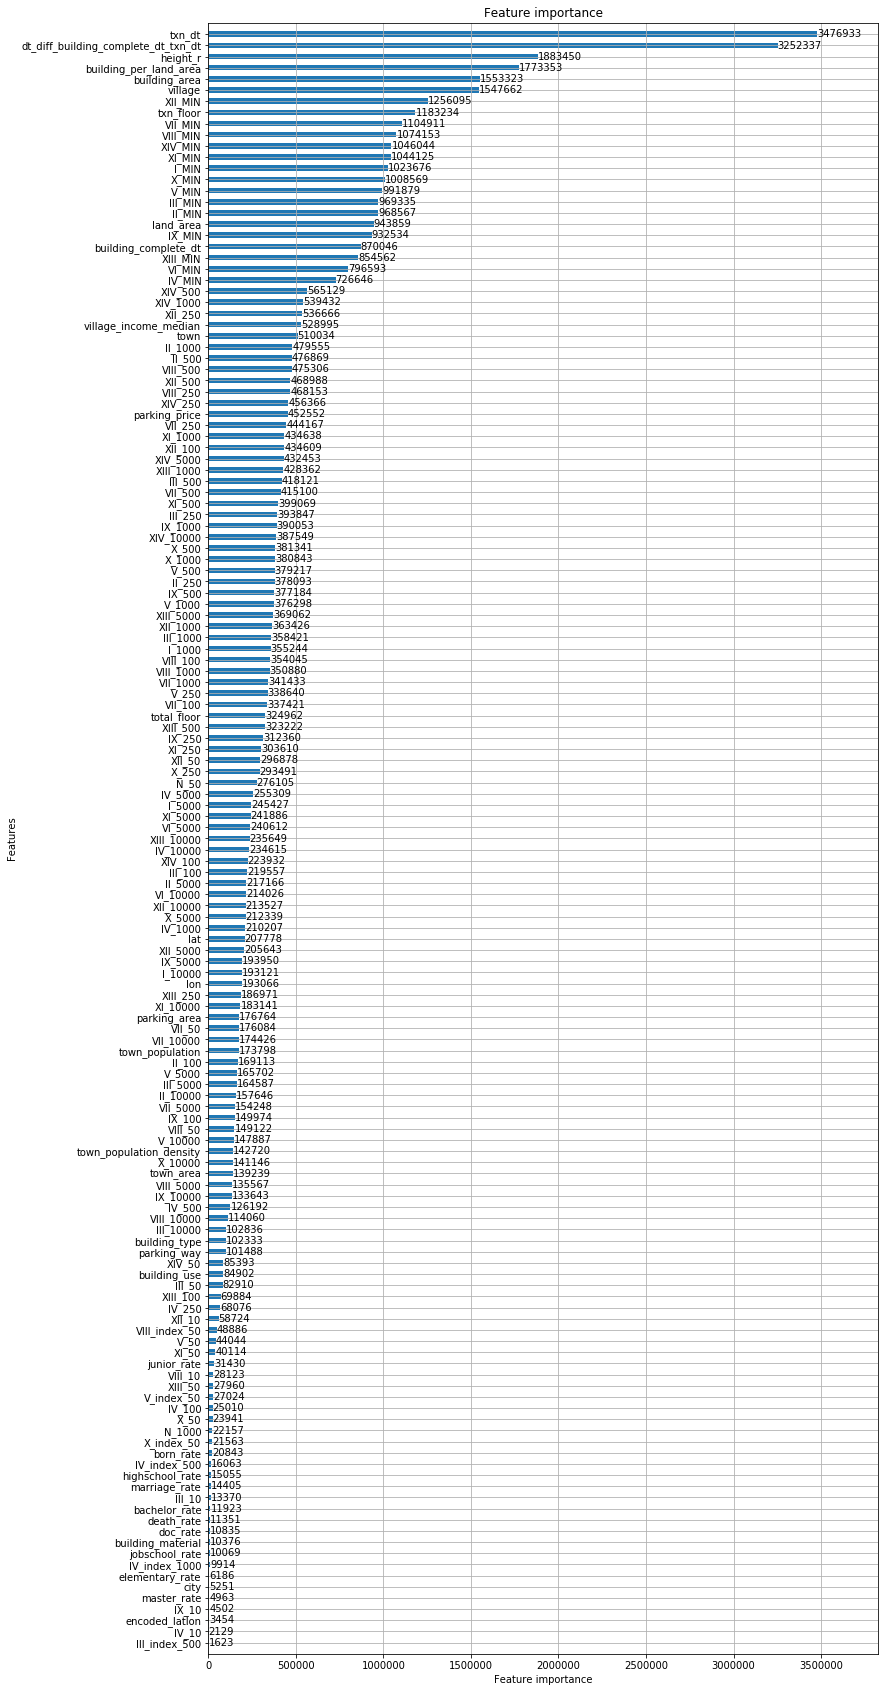

In [24]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

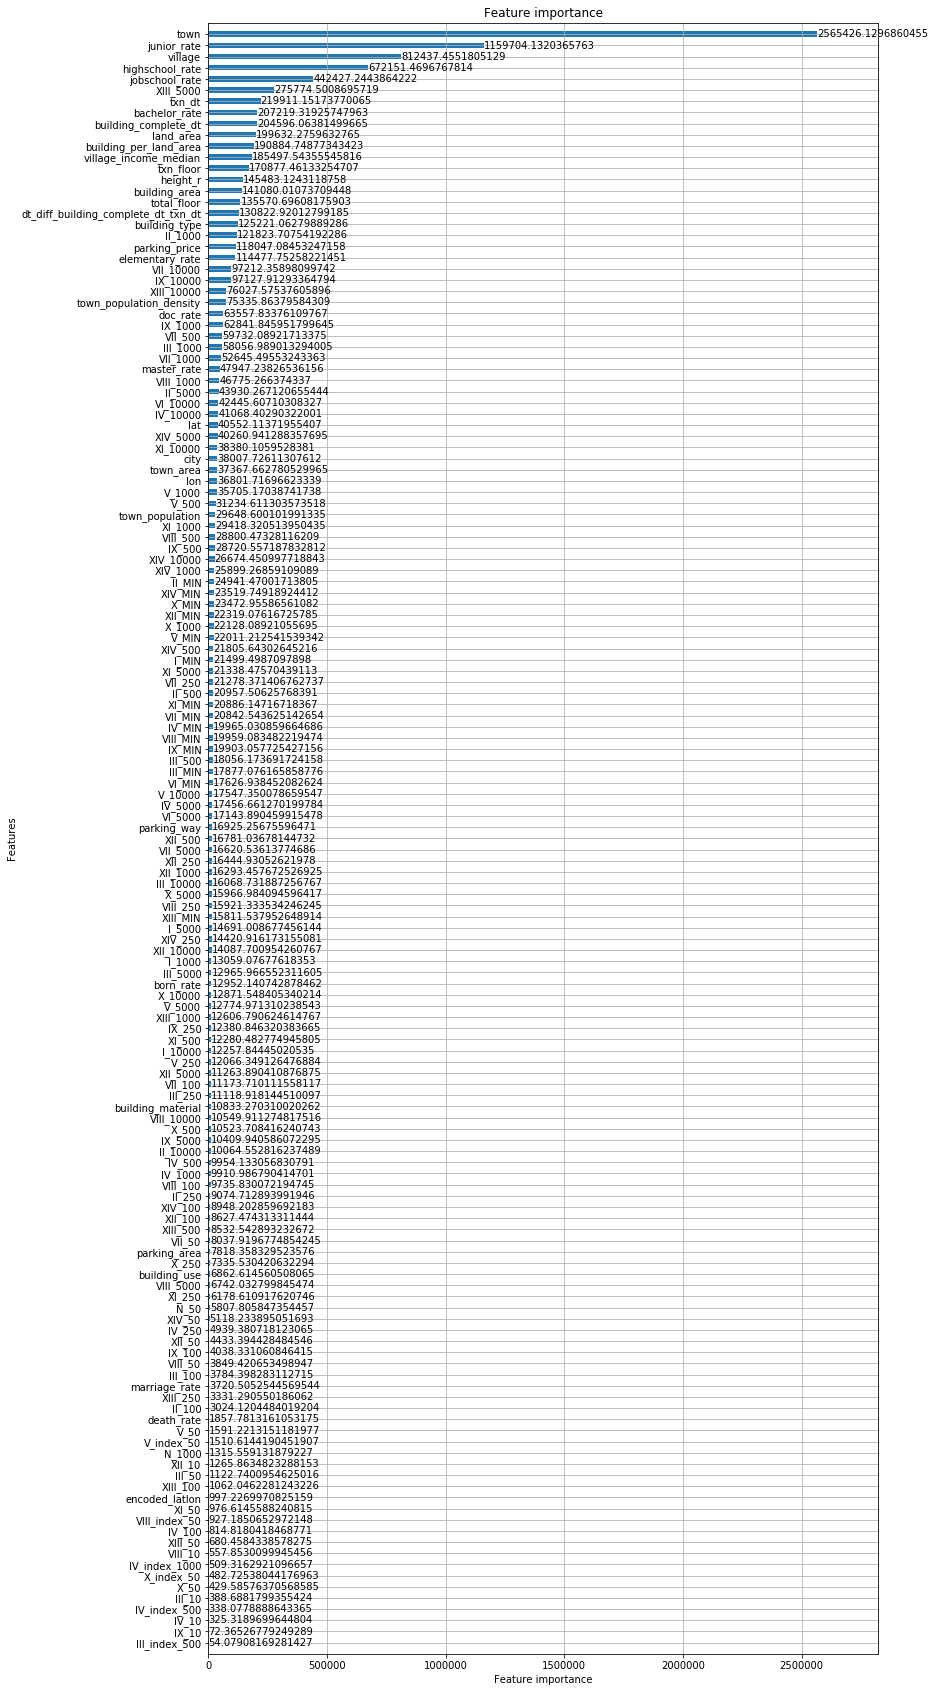

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()